# COVID-19 Interactive Analysis Dashboard

Coronaviruses are a large family of viruses that may cause respiratory illnesses in humans ranging from common colds to more severe conditions such as Severe Acute Respiratory Syndrome (SARS) and Middle Eastern Respiratory Syndrome (MERS).1 'Novel coronavirus' is a new, previously unidentified strain of coronavirus. 
The novel coronavirus involved in the current outbreak has been named SARS-CoV-2 by the World Health Organization (WHO). 
The disease it causes has been named “coronavirus disease 2019” (or “COVID-19”).

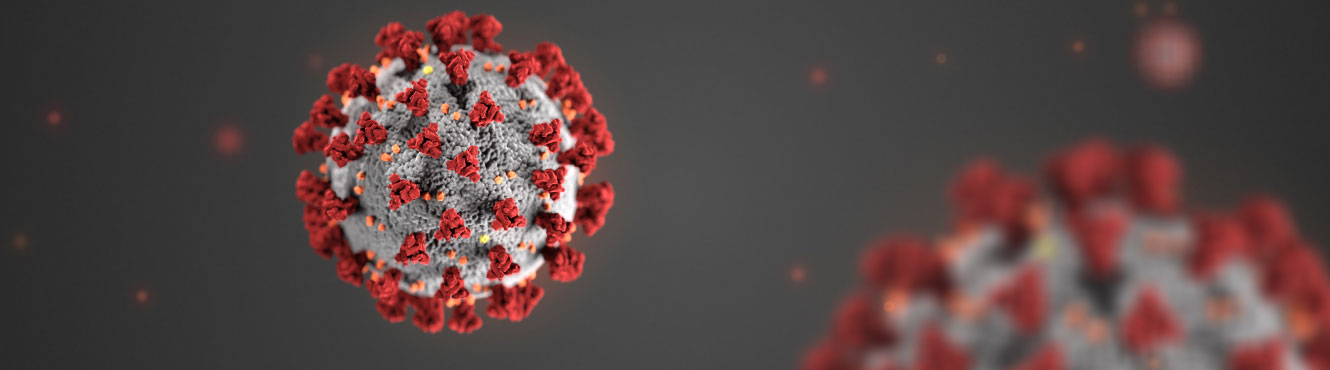

In [1]:
# importing libraries

from ipywidgets import interact
from IPython.core.display import display, HTML

import numpy as np
import pandas as pd
import plotly.express as px
import folium
import plotly.graph_objects as go

In [2]:
# loading data right from the source:

#https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

#https://github.com/CSSEGISandData/COVID-19/tree/web-data/data
country_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')

In [3]:
#drop rows with NaN values in location to avoid world map load issue
confirmed_df.dropna(axis = 0, inplace = True, subset=['Lat', 'Long'])

In [4]:
#confirmed_df.head()

In [5]:
#recovered_df.head()

In [6]:
#death_df.head()

In [7]:
#country_df.head()

In [8]:
# data cleaning

# renaming the df column names to lowercase
country_df.columns = map(str.lower, country_df.columns)
confirmed_df.columns = map(str.lower, confirmed_df.columns)
death_df.columns = map(str.lower, death_df.columns)
recovered_df.columns = map(str.lower, recovered_df.columns)

# changing province/state to state and country/region to country
confirmed_df = confirmed_df.rename(columns={'province/state': 'state', 'country/region': 'country'})
recovered_df = confirmed_df.rename(columns={'province/state': 'state', 'country/region': 'country'})
death_df = death_df.rename(columns={'province/state': 'state', 'country/region': 'country'})
country_df = country_df.rename(columns={'country_region': 'country'})
#country_df.head()

In [9]:
# total number of confirmed, death and recovered cases
confirmed_total = int(country_df['confirmed'].sum())
deaths_total = int(country_df['deaths'].sum())
temp = np.sum(np.asarray(recovered_df.iloc[:,4:]),axis = 0)
recovered_total = temp[-1]

In [10]:
# displaying the total stats

display(HTML("<div style = 'background-color: #504e4e; padding: 30px '>" +
             "<span style='color: #fff; font-size:30px;'> Confirmed: "  + str(confirmed_total) +"</span>" +
             "<span style='color: red; font-size:30px;margin-left:20px;'> Deaths: " + str(deaths_total) + "</span>"+
             "<span style='color: lightgreen; font-size:30px; margin-left:20px;'> Recovered: " + str(recovered_total) + "</span>"+
             "</div>")
       )

# COVID-19 Confirmed/Death/Recovered cases by countries
### Enter number of countries you want the data for

In [11]:
#intializing figure object
fig = go.FigureWidget( layout=go.Layout() )

#function to highlight specific columns of a dataframe passed as an argument
def highlight_col(x):
    r = 'background-color: red'
    p = 'background-color: purple'
    g = 'background-color: grey'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    #assigning purple, red and grey color to confirmed, deaths, recovered columns respectively
    df1.iloc[:, 4] = p
    df1.iloc[:, 5] = r
    df1.iloc[:, 6] = g
    return df1

#function to return top 'n' countries adversely affected from covid with highlighted columns
def show_latest_cases(n):
    n = int(n)
    return country_df.sort_values('confirmed', ascending= False).head(n).style.apply(highlight_col, axis=None)
   

#interactive text box
interact(show_latest_cases, n='10')

interactive(children=(Text(value='10', description='n'), Output()), _dom_classes=('widget-interact',))

<function __main__.show_latest_cases(n)>

In [12]:
#sorting the values by confirmed column in descednding order
sorted_country_df = country_df.sort_values('confirmed', ascending= False)
#sorted_country_df

## Slide to check for the worst hit countries 

In [13]:
#plotting the 'n' worst hit countries

#function to plot bubble chart of 'n' Worst hit countries
def bubble_chart(n):
    fig = px.scatter(sorted_country_df.head(n), x="country", y="confirmed", size="confirmed", color="country",
                     hover_name="country", size_max=70)
    fig.update_layout(
    title=str(n) +" Worst hit countries",
    xaxis_title="Countries",
    yaxis_title="Confirmed Cases",
    width = 700
    )
    fig.show();

#interactive slider to set the value of 'n'
interact(bubble_chart, n=10)

interactive(children=(IntSlider(value=10, description='n', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.bubble_chart(n)>

In [14]:
#function to plot a country specific graph between dates & confirmed cases - deaths
def plot_cases_of_a_country(country):
    labels = ['confirmed', 'deaths']
    colors = ['blue', 'red']
    line_size = [4, 5]
    
    df_list = [confirmed_df, death_df]
    
    fig = go.Figure();
    
    for i, df in enumerate(df_list):
        if country == 'World' or country == 'world':
            #extracting all dates in a list
            x_data = np.array(list(df.iloc[:, 4:].columns))
            #extracting sum of confirmed cases on specific date worldwide
            y_data = np.sum(np.asarray(df.iloc[:,4:]),axis = 0)
            
        else:   
            x_data = np.array(list(df.iloc[:, 4:].columns))
            #extracting sum of confirmed cases on specific date of a country
            y_data = np.sum(np.asarray(df[df['country'] == country].iloc[:,4:]),axis = 0)
            
        #adding confirmed and deaths graph line to the figure along with their label names, colors and line-width sizes
        fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
        text = "Total " + str(labels[i]) +": "+ str(y_data[-1])
        ));
    
    #updating layout of figure
    fig.update_layout(
        title="COVID 19 cases of " + country,
        xaxis_title='Date',
        yaxis_title='No. of Confirmed Cases',
        margin=dict(l=20, r=20, t=50, b=20),
        paper_bgcolor="lightgrey",
        width = 800,
        
    );
    
    fig.show();


## Check the details of your country or the World
### Enter the name of your country(in capitalized format(e.g. India)) and world for total cases

In [15]:
#adds an interactive text box to enter country name
interact(plot_cases_of_a_country, country='World')


interactive(children=(Text(value='World', description='country'), Output()), _dom_classes=('widget-interact',)…

<function __main__.plot_cases_of_a_country(country)>

## Worst hit countries - Confirmed cases

In [16]:
#graph of Top 10 worst affected countries - Confirmed Cases
px.bar( 
    sorted_country_df.head(10),
    #provide column names from dataframe to plot bar graph
    x = "country",
    y = "confirmed",
    title= "Top 10 worst affected countries - CONFIRMED CASES",
    color_discrete_sequence=["pink"], 
    height=500,
    width=800
)

## Worst hit countries - Death cases

In [17]:
#graph of Top 10 worst affected countries - Death Cases
px.bar(
    sorted_country_df.head(10),
    #provide column names to plot bar graph
    x = "country",
    y = "deaths",
    title= "Top 10 worst affected countries - DEATH CASES",
    color_discrete_sequence=["pink"], 
    height=500,
    width=800
)

## Worst hit countries - Recovered cases

In [18]:
#graph of Top 10 worst affected countries - Recovered Cases
# def rec(df):
#     c = list(df['country'].unique())
#     j=0
#     for i in c:
#         temp = np.sum(np.asarray(df[df['country'] == i].iloc[:,4:]),axis = 0)
#         df[j]['recovered'] = temp[-1]
#         j+=1
#     return df

# tdf = rec(sorted_country_df.head(10))
px.bar(
    sorted_country_df.head(10),
    x = "country",
    y = "recovered",
    title= "Top 10 worst affected countries - RECOVERED CASES",
    color_discrete_sequence=["pink"], 
    height=500,
    width=800
)

## Global spread of COVID-19 

In [19]:
#intializing world map
world_map = folium.Map(location=[20,0], tiles="cartodbpositron", zoom_start=2, max_zoom = 6, min_zoom = 2)

#creating circles for every affected country 
for i in range(0,len(confirmed_df)):
    folium.Circle(
        location=[confirmed_df.iloc[i]['lat'], confirmed_df.iloc[i]['long']],
        fill=True,
        #any integer value to be used as a radius for the circles
        radius=(int((np.log(confirmed_df.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='red',
        fill_color='indigo',
        tooltip = "<div style='margin: 0; background-color: black; color: white;'>"+
                    "<h4 style='text-align:center;font-weight: bold'>"+confirmed_df.iloc[i]['country'] + "</h4>"
                    "<hr style='margin:10px;color: white;'>"+
                    "<ul style='color: white;;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
                        "<li>Confirmed: "+str(confirmed_df.iloc[i,-1])+"</li>"+
                        "<li>Deaths:   "+str(death_df.iloc[i,-1])+"</li>"+
                    "</ul></div>",
        ).add_to(world_map)

world_map


# More Info on COVID:
#### https://www.who.int/health-topics/coronavirus
#### https://www.who.int/emergencies/diseases/novel-coronavirus-2019

# Link to the GitHub repo for Dataset:
#### https://github.com/CSSEGISandData/COVID-19